# FB Prophet Model - Wage Rate ($)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

In [1]:
# Import packages
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from io import StringIO
import requests
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
import plotly.io as pio

## Data Loading

In [2]:
# Load data from Google Drive
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  # Ensure no error occurred

# Load the CSV directly into a DataFrame
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

In [3]:
# Prepare and process data
df_selected = df[['ref_date', 'value_wage']].copy()
df_grouped = df_selected.groupby('ref_date').agg(
    median_wage=('value_wage', 'median')
).reset_index()
df_grouped['ref_date'] = pd.to_datetime(df_grouped['ref_date'])
df_grouped.set_index('ref_date', inplace=True)

# FB Prophet Model

## Assign Training & Testing Sets

In [4]:
# Split into training and testing sets
train_data = df_grouped['1997-01-01':'2020-12-01']
test_data = df_grouped['2021-01-01':'2023-12-01']
train_data = train_data.reset_index().rename(columns={'ref_date': 'ds', 'median_wage': 'y'})
test_data = test_data.reset_index().rename(columns={'ref_date': 'ds', 'median_wage': 'y'})


# Cross Validation

In [5]:
# Optuna optimization
def optimize_prophet(trial):
    # Define hyperparameters
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Initialize model with suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()

# Model Parameters

In [6]:
# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_prophet, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train model with optimized parameters
optimized_model = Prophet(**best_params)
optimized_model.fit(train_data)

[I 2024-11-30 20:37:15,515] A new study created in memory with name: no-name-33a88db2-8992-4822-93b2-a01223ae1b0f
20:37:15 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:16 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing
20:37:16 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing
20:37:16 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:16,789] Trial 0 finished with value: 0.5368812431843325 and parameters: {'changepoint_prior_scale': 0.06526364954151834, 'seasonality_prior_scale': 0.0807033203024539, 'holidays_prior_scale': 2.4152645546655718, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 0.5368812431843325.
20:37:16 - cmdstanpy - INFO - Chain [1] start processing
20:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:17 - cmdstanpy - INFO - Chain [1] start processing
20:37:17 - cmdstanpy - INFO - Chain [1] done processing
20:37:17 - cmdstanpy - INFO - Chain [1] start processing
20:37:17 - cmdstanpy - INFO - Chain [1] done processing
20:37:17 - cmdstanpy - INFO - Chain [1] start processing
20:37:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:17,749] Trial 1 finished with value: 0.48597396476486127 and parameters: {'changepoint_prior_scale': 0.007352360414902629, 'seasonality_prior_scale': 0.9286097282190919, 'holidays_prior_scale': 0.5693039454973982, 'seasonality_mode': 'additive'}. Best is trial 1 with value: 0.48597396476486127.
20:37:17 - cmdstanpy - INFO - Chain [1] start processing
20:37:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:18 - cmdstanpy - INFO - Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing
20:37:18 - cmdstanpy - INFO - Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing
20:37:18 - cmdstanpy - INFO - Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:18,682] Trial 2 finished with value: 0.47906739069103543 and parameters: {'changepoint_prior_scale': 0.005180830183531323, 'seasonality_prior_scale': 3.0015026305777743, 'holidays_prior_scale': 0.3385104810071984, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.47906739069103543.
20:37:18 - cmdstanpy - INFO - Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:19 - cmdstanpy - INFO - Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing
20:37:19 - cmdstanpy - INFO - Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing
20:37:19 - cmdstanpy - INFO - Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:19,670] Trial 3 finished with value: 0.5374440564131278 and parameters: {'changepoint_prior_scale': 0.047451613997211706, 'seasonality_prior_scale': 0.5006747861236496, 'holidays_prior_scale': 1.6421681361946279, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.47906739069103543.
20:37:19 - cmdstanpy - INFO - Chain [1] start processing
20:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:20,608] Trial 4 finished with value: 0.5480228969529084 and parameters: {'changepoint_prior_scale': 0.017104641916517165, 'seasonality_prior_scale': 0.09172451083897398, 'holidays_prior_scale': 0.027396163259547805, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.47906739069103543.
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing
20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing
20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:21,518] Trial 5 finished with value: 0.49471434495404604 and parameters: {'changepoint_prior_scale': 0.009176524439150192, 'seasonality_prior_scale': 8.783261212754324, 'holidays_prior_scale': 0.1601397946508114, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.47906739069103543.
20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:21 - cmdstanpy - INFO - Chain [1] start processing
20:37:22 - cmdstanpy - INFO - Chain [1] done processing
20:37:22 - cmdstanpy - INFO - Chain [1] start processing
20:37:22 - cmdstanpy - INFO - Chain [1] done processing
20:37:22 - cmdstanpy - INFO - Chain [1] start processing
20:37:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:22,649] Trial 6 finished with value: 0.5303453199747555 and parameters: {'changepoint_prior_scale': 0.4363848727613798, 'seasonality_prior_scale': 0.6650619316316358, 'holidays_prior_scale': 2.099491141040224, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.47906739069103543.
20:37:22 - cmdstanpy - INFO - Chain [1] start processing
20:37:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:22 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing
20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing
20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:23,616] Trial 7 finished with value: 0.4850589767552606 and parameters: {'changepoint_prior_scale': 0.0615647253249162, 'seasonality_prior_scale': 3.4373699837864495, 'holidays_prior_scale': 0.06083858028410445, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.47906739069103543.
20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:23 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:24,508] Trial 8 finished with value: 0.5185282497615203 and parameters: {'changepoint_prior_scale': 0.0026013356190758793, 'seasonality_prior_scale': 0.6377006107738035, 'holidays_prior_scale': 4.383159782705927, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 0.47906739069103543.
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:25,412] Trial 9 finished with value: 0.49331661859384096 and parameters: {'changepoint_prior_scale': 0.00784206986696421, 'seasonality_prior_scale': 0.16119234641166766, 'holidays_prior_scale': 0.07010746443253006, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 0.47906739069103543.
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:26,273] Trial 10 finished with value: 0.45000893925174307 and parameters: {'changepoint_prior_scale': 0.001014329497461028, 'seasonality_prior_scale': 0.019099049481204007, 'holidays_prior_scale': 0.010729182947235894, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.45000893925174307.
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:27,189] Trial 11 finished with value: 0.45247633826385497 and parameters: {'changepoint_prior_scale': 0.0012598628215744828, 'seasonality_prior_scale': 0.01063940484365957, 'holidays_prior_scale': 0.010282467474256972, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.45000893925174307.
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1] done processing
20:37:27 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:28,088] Trial 12 finished with value: 0.4562695074817746 and parameters: {'changepoint_prior_scale': 0.0010524603230434087, 'seasonality_prior_scale': 0.011838745974949409, 'holidays_prior_scale': 0.010109224965792247, 'seasonality_mode': 'additive'}. Best is trial 10 with value: 0.45000893925174307.
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:29,023] Trial 13 finished with value: 0.44130664351205745 and parameters: {'changepoint_prior_scale': 0.001138776095084091, 'seasonality_prior_scale': 0.0108855093905696, 'holidays_prior_scale': 0.011101209385363924, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:29 - cmdstanpy - INFO - Chain [1] start processing
20:37:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:29 - cmdstanpy - INFO - Chain [1] start processing
20:37:29 - cmdstanpy - INFO - Chain [1] done processing
20:37:29 - cmdstanpy - INFO - Chain [1] start processing
20:37:29 - cmdstanpy - INFO - Chain [1] done processing
20:37:29 - cmdstanpy - INFO - Chain [1] start processing
20:37:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:29,876] Trial 14 finished with value: 0.4653818820373465 and parameters: {'changepoint_prior_scale': 0.0022817202913338573, 'seasonality_prior_scale': 0.029997952778574623, 'holidays_prior_scale': 0.028968037136948777, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:30 - cmdstanpy - INFO - Chain [1] start processing
20:37:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:30 - cmdstanpy - INFO - Chain [1] start processing
20:37:30 - cmdstanpy - INFO - Chain [1] done processing
20:37:30 - cmdstanpy - INFO - Chain [1] start processing
20:37:30 - cmdstanpy - INFO - Chain [1] done processing
20:37:30 - cmdstanpy - INFO - Chain [1] start processing
20:37:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:30,789] Trial 15 finished with value: 0.4603824942508894 and parameters: {'changepoint_prior_scale': 0.002559436884537407, 'seasonality_prior_scale': 0.03259764208761216, 'holidays_prior_scale': 0.025624427430911634, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:30 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing
20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing
20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:31,844] Trial 16 finished with value: 0.4789623551329029 and parameters: {'changepoint_prior_scale': 0.23703389938908623, 'seasonality_prior_scale': 0.02837225266044033, 'holidays_prior_scale': 0.13027769843384646, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:31 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:32 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing
20:37:32 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:32,707] Trial 17 finished with value: 0.4702695548373556 and parameters: {'changepoint_prior_scale': 0.0037632631674317514, 'seasonality_prior_scale': 0.02146899112411452, 'holidays_prior_scale': 0.02168690450146797, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:32 - cmdstanpy - INFO - Chain [1] start processing
20:37:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:33,586] Trial 18 finished with value: 0.44395309190160775 and parameters: {'changepoint_prior_scale': 0.0010185475360199737, 'seasonality_prior_scale': 0.0808962993697227, 'holidays_prior_scale': 0.06500121837286778, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:33 - cmdstanpy - INFO - Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
20:37:34 - cmdstanpy - INFO - Chain [1] start processing
20:37:34 - cmdstanpy - INFO - Chain [1] done processing
20:37:34 - cmdstanpy - INFO - Chain [1] start processing
20:37:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:34,483] Trial 19 finished with value: 0.5005239087222617 and parameters: {'changepoint_prior_scale': 0.016440206772981827, 'seasonality_prior_scale': 0.06932576273551748, 'holidays_prior_scale': 0.05824983567355406, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:34 - cmdstanpy - INFO - Chain [1] start processing
20:37:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:34 - cmdstanpy - INFO - Chain [1] start processing
20:37:34 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:35,373] Trial 20 finished with value: 0.4452530512953167 and parameters: {'changepoint_prior_scale': 0.0016375741669123862, 'seasonality_prior_scale': 0.18065279987006078, 'holidays_prior_scale': 0.651993472321548, 'seasonality_mode': 'additive'}. Best is trial 13 with value: 0.44130664351205745.
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing
20:37:35 - cmdstanpy - INFO - Chain [1] start processing
20:37:35 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:36,217] Trial 21 finished with value: 0.43534918143834056 and parameters: {'changepoint_prior_scale': 0.0020108824174633966, 'seasonality_prior_scale': 0.27854005620397565, 'holidays_prior_scale': 0.7057630051357859, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:37,082] Trial 22 finished with value: 0.4370448029450257 and parameters: {'changepoint_prior_scale': 0.0018438415913758109, 'seasonality_prior_scale': 0.2563641944500234, 'holidays_prior_scale': 0.9341095823950678, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing
20:37:37 - cmdstanpy - INFO - Chain [1] start processing
20:37:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:37,987] Trial 23 finished with value: 0.4711296495071546 and parameters: {'changepoint_prior_scale': 0.003898077857350221, 'seasonality_prior_scale': 0.23124696636821235, 'holidays_prior_scale': 9.508660034366834, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing
20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing
20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:38,858] Trial 24 finished with value: 0.45505871807751336 and parameters: {'changepoint_prior_scale': 0.0016642856303386818, 'seasonality_prior_scale': 1.377990170931457, 'holidays_prior_scale': 0.832505880574308, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:38 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing
20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing
20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:39,766] Trial 25 finished with value: 0.5109272917697901 and parameters: {'changepoint_prior_scale': 0.004164092821208831, 'seasonality_prior_scale': 0.28378341512617544, 'holidays_prior_scale': 0.2895081395793917, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:39 - cmdstanpy - INFO - Chain [1] start processing
20:37:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing
20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing
20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:40,591] Trial 26 finished with value: 0.5306185761507927 and parameters: {'changepoint_prior_scale': 0.0021660881023220515, 'seasonality_prior_scale': 1.8569855460149922, 'holidays_prior_scale': 1.111365070522664, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 0.43534918143834056.
20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing
20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing
20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:41,552] Trial 27 finished with value: 0.4866572703878718 and parameters: {'changepoint_prior_scale': 0.03801272801335632, 'seasonality_prior_scale': 0.3836379780633425, 'holidays_prior_scale': 0.3580490341314636, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:41 - cmdstanpy - INFO - Chain [1] start processing
20:37:41 - cmdstanpy - INFO - Chain [1] done processing
20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing
20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:42,450] Trial 28 finished with value: 0.48680517472216445 and parameters: {'changepoint_prior_scale': 0.00596797442976703, 'seasonality_prior_scale': 0.04699808778152299, 'holidays_prior_scale': 0.18885708870469212, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:37:42 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:43,466] Trial 29 finished with value: 0.5377820711698252 and parameters: {'changepoint_prior_scale': 0.12989397461673655, 'seasonality_prior_scale': 0.12019524643191976, 'holidays_prior_scale': 3.1100805702229666, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 0.43534918143834056.
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:44,407] Trial 30 finished with value: 0.5046477681599033 and parameters: {'changepoint_prior_scale': 0.012304579770624501, 'seasonality_prior_scale': 9.190119600474446, 'holidays_prior_scale': 4.9864226729722, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:45,264] Trial 31 finished with value: 0.447246232560675 and parameters: {'changepoint_prior_scale': 0.0015927508523995795, 'seasonality_prior_scale': 0.05205009308586717, 'holidays_prior_scale': 0.09464277532009419, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing
20:37:45 - cmdstanpy - INFO - Chain [1] start processing
20:37:45 - cmdstanpy - INFO - Chain [1] done processing
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:46,164] Trial 32 finished with value: 0.4452485276638687 and parameters: {'changepoint_prior_scale': 0.0029000148775519935, 'seasonality_prior_scale': 0.10320770627503498, 'holidays_prior_scale': 1.275202860815073, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing
20:37:46 - cmdstanpy - INFO - Chain [1] start processing
20:37:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:47,039] Trial 33 finished with value: 0.4433821574329053 and parameters: {'changepoint_prior_scale': 0.001462087854420441, 'seasonality_prior_scale': 0.15655402287777176, 'holidays_prior_scale': 0.47169554764272237, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:47 - cmdstanpy - INFO - Chain [1] start processing
20:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:47 - cmdstanpy - INFO - Chain [1] start processing
20:37:47 - cmdstanpy - INFO - Chain [1] done processing
20:37:47 - cmdstanpy - INFO - Chain [1] start processing
20:37:47 - cmdstanpy - INFO - Chain [1] done processing
20:37:47 - cmdstanpy - INFO - Chain [1] start processing
20:37:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:47,909] Trial 34 finished with value: 0.45418124287882394 and parameters: {'changepoint_prior_scale': 0.0016483123467306148, 'seasonality_prior_scale': 0.3492098069360026, 'holidays_prior_scale': 0.4046535589518621, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:48 - cmdstanpy - INFO - Chain [1] start processing
20:37:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:48 - cmdstanpy - INFO - Chain [1] start processing
20:37:48 - cmdstanpy - INFO - Chain [1] done processing
20:37:48 - cmdstanpy - INFO - Chain [1] start processing
20:37:48 - cmdstanpy - INFO - Chain [1] done processing
20:37:48 - cmdstanpy - INFO - Chain [1] start processing
20:37:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:48,824] Trial 35 finished with value: 0.4828746102907466 and parameters: {'changepoint_prior_scale': 0.005570463408594792, 'seasonality_prior_scale': 1.2937728265951631, 'holidays_prior_scale': 0.6050892099810302, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:48 - cmdstanpy - INFO - Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:49 - cmdstanpy - INFO - Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing
20:37:49 - cmdstanpy - INFO - Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing
20:37:49 - cmdstanpy - INFO - Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:49,705] Trial 36 finished with value: 0.5244887700746345 and parameters: {'changepoint_prior_scale': 0.003089121946352777, 'seasonality_prior_scale': 0.14963243286898664, 'holidays_prior_scale': 0.2453708252126919, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 0.43534918143834056.
20:37:49 - cmdstanpy - INFO - Chain [1] start processing
20:37:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:50 - cmdstanpy - INFO - Chain [1] start processing
20:37:50 - cmdstanpy - INFO - Chain [1] done processing
20:37:50 - cmdstanpy - INFO - Chain [1] start processing
20:37:50 - cmdstanpy - INFO - Chain [1] done processing
20:37:50 - cmdstanpy - INFO - Chain [1] start processing
20:37:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:50,681] Trial 37 finished with value: 0.48782154048760834 and parameters: {'changepoint_prior_scale': 0.032332126930146234, 'seasonality_prior_scale': 0.5553727502869521, 'holidays_prior_scale': 1.126983972916928, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:50 - cmdstanpy - INFO - Chain [1] start processing
20:37:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing
20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing
20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:51,553] Trial 38 finished with value: 0.4380548241545561 and parameters: {'changepoint_prior_scale': 0.0017977594659259108, 'seasonality_prior_scale': 1.0050971105141502, 'holidays_prior_scale': 0.5061359836109969, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:51 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:52,517] Trial 39 finished with value: 0.5523170444326997 and parameters: {'changepoint_prior_scale': 0.0115045348471727, 'seasonality_prior_scale': 4.243784866333133, 'holidays_prior_scale': 2.4288084695962526, 'seasonality_mode': 'multiplicative'}. Best is trial 21 with value: 0.43534918143834056.
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:53,385] Trial 40 finished with value: 0.4764433161093873 and parameters: {'changepoint_prior_scale': 0.004659623158001098, 'seasonality_prior_scale': 0.956105257312615, 'holidays_prior_scale': 0.7492534631847255, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing
20:37:53 - cmdstanpy - INFO - Chain [1] start processing
20:37:53 - cmdstanpy - INFO - Chain [1] done processing
20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:54,226] Trial 41 finished with value: 0.44047959752255433 and parameters: {'changepoint_prior_scale': 0.0019686366736668477, 'seasonality_prior_scale': 0.2263695248142932, 'holidays_prior_scale': 0.4622510923955959, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing
20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:54 - cmdstanpy - INFO - Chain [1] done processing
20:37:54 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:55,112] Trial 42 finished with value: 0.4440288298053108 and parameters: {'changepoint_prior_scale': 0.0020734591845051114, 'seasonality_prior_scale': 0.42851779759668507, 'holidays_prior_scale': 1.5142427271314423, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 0.43534918143834056.
20:37:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing
20:37:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing
20:37:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:55,980] Trial 43 finished with value: 0.4280164818557159 and parameters: {'changepoint_prior_scale': 0.0019875087272971147, 'seasonality_prior_scale': 0.8330949475466385, 'holidays_prior_scale': 0.8455095717588852, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:37:56 - cmdstanpy - INFO - Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:56 - cmdstanpy - INFO - Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing
20:37:56 - cmdstanpy - INFO - Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing
20:37:56 - cmdstanpy - INFO - Chain [1] start processing
20:37:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:56,887] Trial 44 finished with value: 0.4506906780306428 and parameters: {'changepoint_prior_scale': 0.0032602317219996117, 'seasonality_prior_scale': 0.8446183749561518, 'holidays_prior_scale': 0.8960753651488872, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:37:57 - cmdstanpy - INFO - Chain [1] start processing
20:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:57 - cmdstanpy - INFO - Chain [1] start processing
20:37:57 - cmdstanpy - INFO - Chain [1] done processing
20:37:57 - cmdstanpy - INFO - Chain [1] start processing
20:37:57 - cmdstanpy - INFO - Chain [1] done processing
20:37:57 - cmdstanpy - INFO - Chain [1] start processing
20:37:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:57,779] Trial 45 finished with value: 0.4859904117242889 and parameters: {'changepoint_prior_scale': 0.007377486673033845, 'seasonality_prior_scale': 0.25654675424569157, 'holidays_prior_scale': 2.0477074297626885, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:37:57 - cmdstanpy - INFO - Chain [1] start processing
20:37:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:58,628] Trial 46 finished with value: 0.45244489920510456 and parameters: {'changepoint_prior_scale': 0.002120759951859179, 'seasonality_prior_scale': 0.7940238995611688, 'holidays_prior_scale': 0.5436093001330706, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing
20:37:59 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing
20:37:59 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:37:59,556] Trial 47 finished with value: 0.5424660689348545 and parameters: {'changepoint_prior_scale': 0.00605695395126573, 'seasonality_prior_scale': 1.842290758364727, 'holidays_prior_scale': 0.2565967127936261, 'seasonality_mode': 'multiplicative'}. Best is trial 43 with value: 0.4280164818557159.
20:37:59 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:37:59 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing
20:38:00 - cmdstanpy - INFO - Chain [1] start processing
20:38:00 - cmdstanpy - INFO - Chain [1] done processing
20:38:00 - cmdstanpy - INFO - Chain [1] start processing
20:38:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:38:00,448] Trial 48 finished with value: 0.45081257015444237 and parameters: {'changepoint_prior_scale': 0.0013006952002907945, 'seasonality_prior_scale': 0.5226591063687978, 'holidays_prior_scale': 0.4566969135787162, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:38:00 - cmdstanpy - INFO - Chain [1] start processing
20:38:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:38:00 - cmdstanpy - INFO - Chain [1] start processing
20:38:00 - cmdstanpy - INFO - Chain [1] done processing
20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing
20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:38:01,484] Trial 49 finished with value: 0.48328569024758783 and parameters: {'changepoint_prior_scale': 0.08900772569123531, 'seasonality_prior_scale': 0.23028971205106788, 'holidays_prior_scale': 0.9225944466866202, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 0.4280164818557159.
20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:38:01 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'changepoint_prior_scale': 0.0019875087272971147, 'seasonality_prior_scale': 0.8330949475466385, 'holidays_prior_scale': 0.8455095717588852, 'seasonality_mode': 'additive'}


# Model Predictions

In [7]:
# Generate the future dataframe and forecast
future = optimized_model.make_future_dataframe(periods=36, freq='ME')  # Add 36 months to the end of training data
forecast = optimized_model.predict(future)

## Evaluate on test data
test_data['ds'] = test_data['ds'].dt.to_period('M').dt.to_timestamp('M')

# Convert to plain datetime for comparison
forecast_dates = pd.to_datetime(forecast['ds'])
test_dates = pd.to_datetime(test_data['ds'])

# Find common dates manually using set operations
common_dates = list(set(forecast_dates) & set(test_dates))  # Use intersection of sets

# Align forecast and test data on common dates
evaluation = test_data.set_index('ds').loc[common_dates]
evaluation = evaluation.join(forecast.set_index('ds')[['yhat']], how='inner')
evaluation = evaluation.dropna(subset=['y', 'yhat'])

# Model evaluation metrics
actuals = evaluation['y'].values
predictions = evaluation['yhat'].values
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print final model evaluation statistics
print(f"Final Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Final Model Evaluation:
Mean Squared Error (MSE): 0.5694219447832282
Root Mean Squared Error (RMSE): 0.7546005199993094
Mean Absolute Error (MAE): 0.562786028287877
Mean Absolute Percentage Error (MAPE): 2.175043156518034


# Visualizations

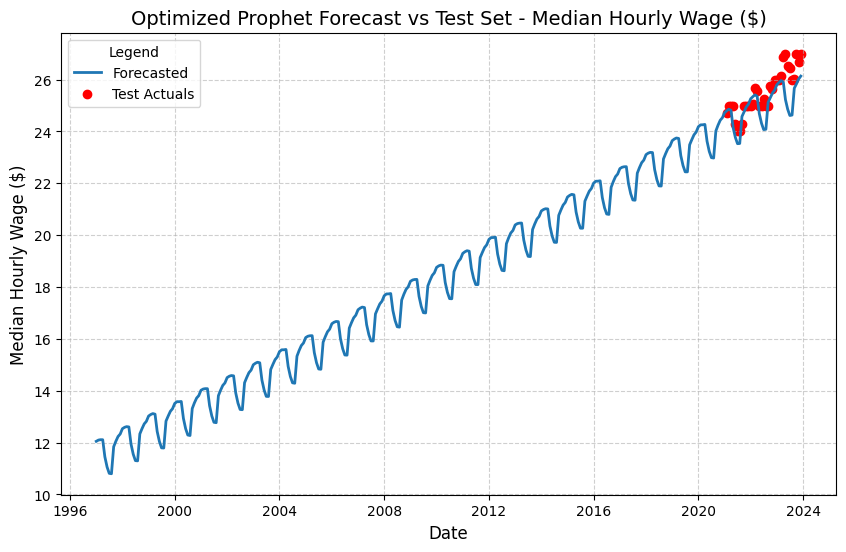

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', linestyle='-', linewidth=2)
plt.scatter(evaluation.index, evaluation['y'], label='Test Actuals', color='red', marker='o')
plt.title("Optimized Prophet Forecast vs Test Set - Median Hourly Wage ($)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Median Hourly Wage ($)", fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

In [9]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add labels and title
fig.update_layout(
    title="Prophet Forecast - Median Hourly Wage ($)",                 
    xaxis_title="Date",                       
    yaxis_title="Median Hourly Wage ($)",        
    legend_title="Legend",                   
    font=dict(size=12),                       
)

# Show plot
fig.show()

In [10]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add test data 
fig.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),  
        marker=dict(color='red')
    )
)

# Adjust x-axis range (2021-2023)
fig.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Hourly Wage ($)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Median Hourly Wage ($)',  # Add plot title
)

# Show plot
fig.show()

In [11]:
# Generate plot
fig = plot_components_plotly(optimized_model, forecast)

# Add title and labels
fig.update_layout(
    title="Prophet Forecast - Median Hourly Wage ($)",     
    font=dict(size=12),                      
)       

# Show plot
fig.show()

# Optional: Download interactive plots (html)

In [12]:
# 1. Generate the first plot
fig1 = plot_plotly(optimized_model, forecast)
fig1.update_layout(
    title="Prophet Forecast - Median Hourly Wage ($)",
    xaxis_title="Date",
    yaxis_title="Median Hourly Wage ($)",
    legend_title="Legend",
    font=dict(size=12),
)

# Save the first plot as an HTML string
html1 = pio.to_html(fig1, full_html=False)

# 2. Generate the second plot
fig2 = plot_plotly(optimized_model, forecast)
fig2.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),
        marker=dict(color='red')
    )
)
fig2.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Hourly Wage ($)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Median Hourly Wage ($)',
)

# Save the second plot as an HTML string
html2 = pio.to_html(fig2, full_html=False)

# 3. Generate the third plot
fig3 = plot_components_plotly(optimized_model, forecast)
fig3.update_layout(
    title="Prophet Forecast - Components (Median Hourly Wage $)",
    font=dict(size=12),
)

# Save the third plot as an HTML string
html3 = pio.to_html(fig3, full_html=False)

# Combine all HTML strings into one HTML file
combined_html = f"""
<html>
<head>
    <title>Prophet Forecast Plots</title>
</head>
<body>
    <h1>Prophet Forecast - Interactive Plots</h1>
    <h2>1. Full Forecast</h2>
    {html1}
    <h2>2. Forecast with Test Data</h2>
    {html2}
    <h2>3. Forecast Components</h2>
    {html3}
</body>
</html>
"""

# Save the combined HTML to a file
with open("FB Prophet forecast plots (wage).html", "w") as f:
    f.write(combined_html)

# Print a message indicating where the file is saved
print("HTML file saved as 'FB Prophet forecast plots (wage).html'. Open this file to view the interactive plots.")


HTML file saved as 'FB Prophet forecast plots (wage).html'. Open this file to view the interactive plots.
